# Load Libraries

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 5.6MB/s 
     |████████████████████████████████| 901kB 17.8MB/s 
     |████████████████████████████████| 3.3MB 27.6MB/s 


In [ ]:
#######################################
### -------- Load libraries ------- ###
# Load Huggingface transformers
from transformers import TFBertModel, BertConfig, BertTokenizer
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
# And pandas for data import + sklearn because you allways need sklearn
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Import the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
files.upload()

Saving 20160101-v2.xlsx to 20160101-v2.xlsx
Saving 20160205-v2.xlsx to 20160205-v2.xlsx


{'20160101-v2.xlsx': b'PK\x03\x04\x14\x00\x08\x08\x08\x00\x0e\x08\x90R\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00xl/drawings/drawing1.xml\x9d\xd0]n\xc20\x0c\x07\xf0\x13\xec\x0eU\xdeiZ\x18\x13C\x14^\xd0N0\x0e\xe0%n\x1b\x91\x8f\xca\x0e\xa3\xdc~\xd1J6i{\x01\x1em\xcb?\xf9\xef\xcdnt\xb6\xf8Db\x13|#\xea\xb2\x12\x05z\x15\xb4\xf1]#\x0e\xefo\xb3\x95(8\x82\xd7`\x83\xc7F\\\x90\xc5n\xfb\xb4\x195\xad\xcf\xbc\xa7"\xed{^\xa7\xb2\x11}\x8c\xc3ZJV=:\xe02\x0c\xe8\xd3\xb4\r\xe4 \xa6\x92:\xa9\t\xceIvV\xce\xab\xeaE\xf2@\x08\x9a{\xc4\xb8\x9f&\xe2\xea\xc1\x03\x9a\x03\xe3\xf3\xfeM\xd7\x84\xb65\n\xf7A\x9d\x1c\xfa8!\x84\x16b\xfa\x05\xf7f\xe0\xac\xa9\x07\xaeQ=P\xfc\x01\xc6\x7f\x823\x8a\x02\x876\x96*\xb8\xeb)\xd9HB\xfd<\t8\xfe\x1a\xf5\xdd\xc8R\xbe\xca\xd5_\xc8\xdd\x14\xc7\x01\x1dO\xc3,\xb9Cz\xc8\x87\xb1&^\xbe\x93eFw\xee\x81\xb7h\x03\x1d\x81\xcb\xc8\xb88\xf8\xe3\xdd\xb1*\xc96\xb5(+l\xb1^\xde\xad\xcc\xb3"\xb7_PK\x07\x08\x07bi\x83\x05\x01\x00\x00\x07\x03\x00\x00PK\x03\x04\x14\x00\x08\x08\x08\x00\

In [ ]:
data1 = pd.read_excel("20160205-v2.xlsx")

In [ ]:
data1.head()

,_id,au,ct,hl,st,label,Positive,Negative,Irony,Subjectivity
0,########,九尾天師,終於到了蓄勢吸籌的價位了,終於到了蓄勢吸籌的價位了,300371.sz,1,1.0,0.0,0.0,1.0
1,202000000000000,市北高新資訊,來源：全景網 編輯：東方財富網\n \n \n \n 市北高新(600604)周四發佈公告稱...,市北高新子公司13.16億競得上海土地,600604.sh,0,1.0,0.0,0.0,0.0
2,202000000000000,黑白問,求下聯！上聯：半個月查三次，不懼減持，十個漲停成妖股。,求下聯！上聯：半個月查三次，不懼減持，十個漲,600610.sh,1,1.0,1.0,1.0,1.0
3,202000000000000,擼親不認,平時健盛集團吧人氣超冷淡，差不多三天才會有人說一句且沒回複的，現在一個漲停即可匯集那麼多人氣...,平時健盛集團吧人氣超冷淡，差不多三天才會有人,603558.sh,1,1.0,1.0,1.0,1.0
4,202000000000000,廣東廣州手機網友,南威極有可能沒高送轉\n 不信看,南威極有可能沒高送轉 不信看,603636.sh,1,1.0,0.0,0.0,1.0


In [ ]:
def clean_xlsx(df):
  df = df[['ct','label']]
  df = df.dropna()
  df = df.groupby('label').filter(lambda x : len(x) > 1)
  return df

In [ ]:
data1 = clean_xlsx(data1)

In [ ]:
data2 = pd.read_excel("20160101-v2.xlsx")

In [ ]:
data2 = clean_xlsx(data2)

In [ ]:
data = pd.concat([data1, data2], ignore_index=True)

# Split the dataset into train and test set.

In [ ]:
def split(df):
  df['label_cat'] = pd.Categorical(df['label'])
  df['label'] = df['label_cat'].cat.codes
  df['ct'] = df['ct'].astype('str') 
  df_train, df_test = train_test_split(df, test_size = 0.15, stratify = df[['label']])
  return df_train, df_test

In [ ]:
data_train, data_test = split(data)

In [ ]:
data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)

In [ ]:
data_train['label'].value_counts(normalize=True)

2    0.371176
1    0.360000
0    0.268824
Name: label, dtype: float64

# Import BERT model and BERT tokenizer

In [ ]:
model_name = 'hfl/chinese-roberta-wwm-ext-large'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert = TFBertModel.from_pretrained(model_name)
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at hfl/chinese-roberta-wwm-ext-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
#sample data
text = ['今天天气很好', '今天股市将崩溃']
#encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
print(sent_id)

{'input_ids': [[101, 791, 1921, 1921, 3698, 2523, 1962, 102, 0], [101, 791, 1921, 5500, 2356, 2199, 2309, 3971, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Data Exploration + Cleaning

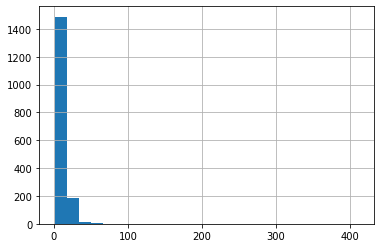

In [ ]:
seq_len = [len(i.split()) for i in data_train['ct']]
pd.Series(seq_len).hist(bins=25)

In [ ]:
#drop long spam messages
index=0
drop=[]
for length in seq_len:
  if length>100:
    drop.append(index)
  index=index+1

In [ ]:
data_train.drop(labels=drop, axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
max_length = 32

# Define Model Architecture

In [ ]:
roberta = bert.layers[0]

In [ ]:
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

#Load the Transformers BERT model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

#output
fc1 = Dense(units=512,activation='relu', kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='fc1')(pooled_output)
fc1_output = Dropout(0.1, name='fc1_output')(fc1)
label = Dense(units=len(data.label_cat.value_counts()),activation='softmax',kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='label')(fc1_output)

output = {'label': label}

In [ ]:
#combined
model = Model(inputs=inputs, outputs=output, name='ROBERTA')
model.summary()

Model: "ROBERTA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 32)]              0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 325522432 
_________________________________________________________________
pooled_output (Dropout)      (None, 1024)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               524800    
_________________________________________________________________
fc1_output (Dropout)         (None, 512)               0         
_________________________________________________________________
label (Dense)                (None, 3)                 1539      
Total params: 326,048,771
Trainable params: 326,048,771
Non-trainable params: 0
_____________________________________________

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamWeightDecay

# define the optimizer
optimizer = AdamWeightDecay(lr = 2e-5, weight_decay_rate=0.02)
# optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)

In [ ]:
loss = {'label': CategoricalCrossentropy(from_logits = True)}
metric = {'label': CategoricalAccuracy('accuracy')}

In [ ]:
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

In [ ]:
y_label = to_categorical(data_train['label'])

In [ ]:
x = tokenizer(text=data_train['ct'].to_list(), add_special_tokens=True, max_length=max_length, truncation=True, padding=True, return_tensors='tf', return_token_type_ids = False, return_attention_mask = False, verbose = True)

In [ ]:
ckpt_path = "bert.ckpt"
cp_callback = ModelCheckpoint(filepath=ckpt_path,save_best_only=True, save_weights_only=True, verbose=1)

In [ ]:
history = model.fit(x={'input_ids': x['input_ids']}, y={'label': y_label}, validation_split=0.15, batch_size=32, epochs=5, callbacks=[cp_callback])

Epoch 1/5
46/46 [==============================] - 116s 2s/step - loss: 1.0723 - accuracy: 0.4142 - val_loss: 0.9705 - val_accuracy: 0.5255

Epoch 00001: val_loss improved from inf to 0.97054, saving model to bert.ckpt
Epoch 2/5
46/46 [==============================] - 68s 1s/step - loss: 0.8694 - accuracy: 0.6337 - val_loss: 0.7497 - val_accuracy: 0.6745

Epoch 00002: val_loss improved from 0.97054 to 0.74974, saving model to bert.ckpt
Epoch 3/5
46/46 [==============================] - 68s 1s/step - loss: 0.5370 - accuracy: 0.8241 - val_loss: 0.7389 - val_accuracy: 0.7059

Epoch 00003: val_loss improved from 0.74974 to 0.73894, saving model to bert.ckpt
Epoch 4/5
46/46 [==============================] - 68s 1s/step - loss: 0.3638 - accuracy: 0.8954 - val_loss: 0.7707 - val_accuracy: 0.7098

Epoch 00004: val_loss did not improve from 0.73894
Epoch 5/5
46/46 [==============================] - 68s 1s/step - loss: 0.2598 - accuracy: 0.9309 - val_loss: 0.9044 - val_accuracy: 0.6941

Epoch 

# Save the best Model to drive

In [ ]:
!cp bert.ckpt.data-00000-of-00001 /content/gdrive/MyDrive

In [ ]:
!cp bert.ckpt.index /content/gdrive/MyDrive

In [ ]:
!cp checkpoint /content/gdrive/MyDrive

# Load the best Model from drive

In [ ]:
!cp /content/gdrive/MyDrive/checkpoint checkpoint

In [ ]:
!cp /content/gdrive/MyDrive/bert.ckpt.index bert.ckpt.index

In [ ]:
!cp /content/gdrive/MyDrive/bert.ckpt.data-00000-of-00001 bert.ckpt.data-00000-of-00001

In [ ]:
checkpoint_dir = os.path.dirname(ckpt_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

# Test Set Evaluation

In [ ]:
test_y_label = to_categorical(data_test['label'])

In [ ]:
test_x = tokenizer( text=data_test['ct'].to_list(), add_special_tokens=True, max_length=max_length, truncation=True, padding=True, return_tensors='tf', return_token_type_ids = False, return_attention_mask = False, verbose = True)

In [ ]:
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'label': test_y_label}
)

10/10 [==============================] - 4s 415ms/step - loss: 0.5573 - accuracy: 0.7933


In [ ]:
y_pred = model.predict(x={'input_ids': test_x['input_ids']})

In [ ]:
y_pred = np.argmax(y_pred['label'], axis=1)

In [ ]:
print(classification_report(data_test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76        81
           1       0.89      0.80      0.84       108
           2       0.74      0.82      0.78       111

    accuracy                           0.79       300
   macro avg       0.80      0.79      0.79       300
weighted avg       0.80      0.79      0.79       300



In [ ]:
pd.crosstab(data_test['label'], y_pred)

col_0,0,1,2
label,,,
0,61,5,15
1,5,86,17
2,14,6,91
